In [1]:
import time
import requests
from datetime import datetime
import os
import io
import html

from openai import AzureOpenAI
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile

import yfinance as yf
from PIL import Image
from dotenv import load_dotenv

In [2]:
load_dotenv()
api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")
email_URI = os.getenv("EMAIL_URI")

In [3]:
client = AzureOpenAI(api_key=api_key,
        api_version=api_version,
        azure_endpoint=api_endpoint)

In [8]:
def get_stock_price(symbol: str) -> float:
    stock = yf.Ticker(symbol)
    price = stock.history(period="1d")['Close'].iloc[-1]
    return price

In [9]:
def send_logic_apps_email(to: str, content: str):
    json_payload = {'to': to, 'content': html.unescape(content)}
    headers = {'Content-Type': 'application/json'}
    response = requests.post(email_URI, json=json_payload, headers=headers)
    if response.status_code == 202:
        print("Email sent to: " + json_payload['to'])

In [4]:
tools_list = [
{"type": "code_interpreter"},
{"type": "function",
    "function": {

        "name": "get_stock_price",
        "description": "Retrieve the latest closing price of a stock using its ticker symbol.",
        "parameters": {
            "type": "object",
            "properties": {
                "symbol": {
                    "type": "string",
                    "description": "The ticker symbol of the stock"
                }
            },
            "required": ["symbol"]
        }
    }
},
{
    "type": "function",
    "function": {
        "name": "send_email",
        "description": "Sends an email to a recipient(s).",
        "parameters": {
            "type": "object",
            "properties": {
                "to": {
                    "type": "string",
                    "description": "The email(s) the email should be sent to."
                },
                "content": {
                    "type": "string",
                    "description": "The content of the email."
                }
            },
            "required": ["to", "content"]
        }
    }
}]

In [6]:
DATA_FOLDER = "data/"
def upload_file(client, path):
    file = client.files.create(file=open(path, "rb"), purpose="assistants")
    return file

arr = os.listdir(DATA_FOLDER)
assistant_files = []
for file in arr:
    filePath =  DATA_FOLDER + file
    assistant_files.append(upload_file(client, filePath))

file_ids = [file.id for file in assistant_files]
file_ids

['assistant-ZEgVgYdHPvHfHYxbMX2l30Jw']

In [7]:
assistant = client.beta.assistants.create(
    name="Portfolio Management Assistant",
    instructions="You are a personal securities trading assistant. Please be polite, professional, helpful, and friendly. "+
    "Use the provided portfolio CSV file to answer the questions. If question is not related to the portfolio or you cannot answer the question, say, 'contact a representative for more assistance.'" +
    "If the user asks for help or says 'help', provide a list of sample questions that you can answer.",
    tools=tools_list, 
    model=api_deployment_name,
    file_ids=file_ids
)

thread = client.beta.threads.create()

In [10]:
def call_functions(client, thread, run):
    print("Function Calling")
    required_actions = run.required_action.submit_tool_outputs.model_dump()
    print(required_actions)
    tool_outputs = []
    import json
    for action in required_actions["tool_calls"]:
        func_name = action['function']['name']
        arguments = json.loads(action['function']['arguments'])
        
        if func_name == "get_stock_price":
            output = get_stock_price(symbol=arguments['symbol'])
            tool_outputs.append({
                "tool_call_id": action['id'],
                "output": output
            })
        elif func_name == "send_email":
            print("Sending email...")
            email_to = arguments['to']
            email_content = arguments['content']
            send_logic_apps_email(email_to,email_content)
            
            tool_outputs.append({
                "tool_call_id": action['id'],
                "output": "Email sent"
            })
        else:
            raise ValueError(f"Unknown function: {func_name}")
        
    print("Submitting outputs back to the Assistant...")
    client.beta.threads.runs.submit_tool_outputs(
        thread_id=thread.id,
        run_id=run.id,
        tool_outputs=tool_outputs
    )

In [12]:
def format_messages(messages):
    message_list = []

    # Get all the messages till the last user message
    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the messages to show the last user message first
    message_list.reverse()

    # Print the user or Assistant messages or images
    for message in message_list:                
        for item in message.content:
            # Determine the content type
            if isinstance(item, MessageContentText):
                print(f'{message.role}:\n{item.text.value}\n')
                file_annotations = item.text.annotations
            elif isinstance(item, MessageContentImageFile):
                # Retrieve image from file id
                response_content = client.files.content(item.image_file.file_id)
                data_in_bytes = response_content.read()
                # Convert bytes to image
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                # Resize image to fit in terminal
                width, height = image.size
                image = image.resize((width //2, height //2), Image.LANCZOS)
                # Display image
                image.show()

In [13]:
def process_message(content:str):
    message = client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=content
    )

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="The current date and time is: " + datetime.now().strftime("%x %X") + "."
    )
    
    print("processing...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
        elif run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            # Handle failed
            break
        elif run.status == "expired":
            # Handle expired
            break
        elif run.status == "cancelled":
            # Handle cancelled
            break
        elif run.status == "requires_action":
            call_functions(client, thread, run)
        else:            
            time.sleep(5)

In [14]:
process_message("Based on the provided portfolio, what investments do I own?")

processing...
user:
Based on the provided portfolio, what investments do I own?

assistant:
The file contains a portfolio with investments structured in CSV format with the following columns:

- `Symbol`: The ticker symbol of the stock
- `Average_Cost`: The average cost paid per share
- `QTY`: The quantity of shares owned

Based on the data within the first 1000 characters, your investments are:

- Microsoft (MSFT)
- Apple (AAPL)
- Amazon (AMZN)
- Tesla (TSLA)
- Netflix (NFLX)
- Nvidia (NVDA)

Would you like me to give you any additional information on these investments, such as their current stock prices or valuations?



In [15]:
process_message("What is the value of my portfolio?")

processing...
Function Calling
{'tool_calls': [{'id': 'call_MP8eTrJ8srVzHrPXz3Dg4m1U', 'function': {'arguments': '{"symbol": "MSFT"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_U9xXo713uxQaPVwXpm4Pd4CR', 'function': {'arguments': '{"symbol": "AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_sswhoh8BsFgn1NO7sZWU4abl', 'function': {'arguments': '{"symbol": "AMZN"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_z7NVFo7kKLUJzIIDUATvh4mM', 'function': {'arguments': '{"symbol": "TSLA"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_x5NRtrtByTxt0rSIrC5VCVgN', 'function': {'arguments': '{"symbol": "NFLX"}', 'name': 'get_stock_price'}, 'type': 'function'}, {'id': 'call_Hwz92FldnRT43QjN2bvSGUPq', 'function': {'arguments': '{"symbol": "NVDA"}', 'name': 'get_stock_price'}, 'type': 'function'}]}
Submitting outputs back to the Assistant...
user:
What is the value of my portfolio?

assistant:
The total value of your investmen

In [16]:
process_message("What is my best and worst investment?")

processing...
user:
What is my best and worst investment?

assistant:
The best investment in your portfolio is Microsoft (MSFT), with a gain of $66,165. You bought it at an average cost of $200 per share, currently valued at $420.55 per share, and you own 300 shares.

The worst investment in your portfolio is Tesla (TSLA), with a loss of $70,643. You bought it at an average cost of $900 per share, currently valued at $193.57 per share, and you own 100 shares.



processing...
user:
Chart the realized gain or loss of my investments.



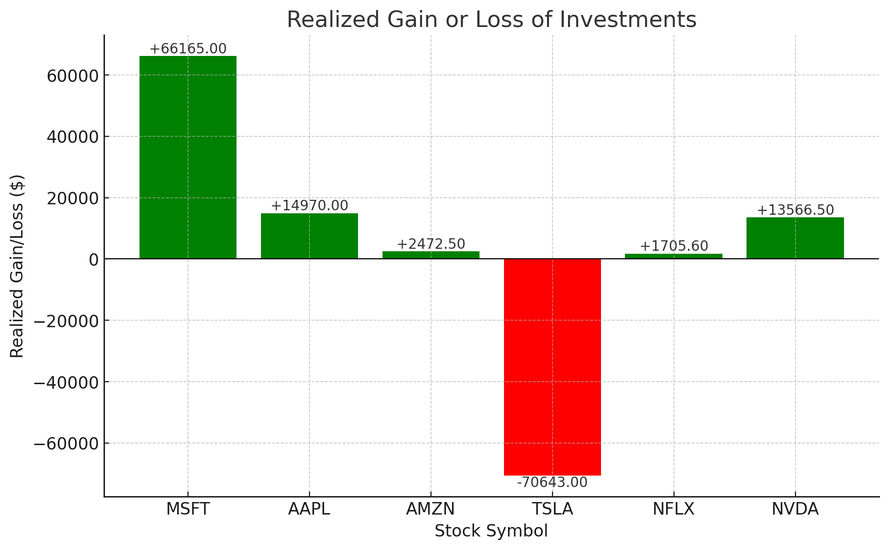

assistant:
I have created a bar chart that displays the realized gain or loss for each of your investments. 

Green bars represent a gain, whereas red bars represent a loss. You can download the chart using the following link:

[Download the chart](sandbox:/mnt/data/realized_gain_loss_chart.png)



In [17]:
process_message("Chart the realized gain or loss of my investments.")

In [18]:
process_message("Please email an HTML formatted report to alemor@microsoft.com with the details for each stock based on the latest stock prices, and list the best and worst performing stocks in my portfolio.")

processing...
Function Calling
{'tool_calls': [{'id': 'call_jeJoEz3zWJHILUZxjNFFqGQw', 'function': {'arguments': '{"to":"alemor@microsoft.com","content":"\\n<html>\\n<head>\\n    <style>\\n        table, th, td {\\n            border: 1px solid black;\\n            border-collapse: collapse;\\n        }\\n        th, td {\\n            padding: 10px;\\n        }\\n        th {\\n            background-color: #f2f2f2;\\n        }\\n    </style>\\n</head>\\n<body>\\n    <h2>Portfolio Report</h2>\\n    <p>Here are the details of your investment portfolio based on the latest stock prices:</p>\\n    <table>\\n        <tr>\\n            <th>Stock Symbol</th>\\n            <th>Average Cost</th>\\n            <th>Quantity</th>\\n            <th>Current Price</th>\\n            <th>Holding Value</th>\\n            <th>Investment Value</th>\\n            <th>Realized Gain/Loss</th>\\n        </tr>\\n        <tr>\\n            <td>MSFT</td>\\n            <td>200.00</td>\\n            <td>300</td>

In [19]:
client.beta.assistants.delete(assistant.id)
client.beta.threads.delete(thread.id)
for file in assistant_files:
    client.files.delete(file.id)